# 2D Kelvin Helmholtz Instability

## Imports

In [1]:
# %pip install ../

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3" 

# numerics
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

# timing
from timeit import default_timer as timer

# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# jf1uids
from jf1uids import SimulationConfig
from jf1uids import get_helper_data
from jf1uids import SimulationParams
from jf1uids import time_integration
from jf1uids.fluid_equations.fluid import construct_primitive_state
from jf1uids import get_registered_variables
from jf1uids.option_classes.simulation_config import finalize_config

## Initiating the Kelvin Helmholtz Instability

In [ ]:
from jf1uids.option_classes.simulation_config import BACKWARDS, FORWARDS, HLL, MINMOD, OSHER, PERIODIC_BOUNDARY, BoundarySettings, BoundarySettings1D

print("👷 Setting up simulation...")

# simulation settings
gamma = 5/3

# spatial domain
box_size = 1.0
num_cells = 12000

fixed_timestep = False
scale_time = False
dt_max = 0.1
num_timesteps = 2000

# setup simulation config
config = SimulationConfig(
    runtime_debugging = False,
    first_order_fallback = True,
    progress_bar = False,
    dimensionality = 2,
    box_size = box_size, 
    num_cells = num_cells,
    fixed_timestep = fixed_timestep,
    differentiation_mode = FORWARDS,
    num_timesteps = num_timesteps,
    boundary_settings = BoundarySettings(x = BoundarySettings1D(PERIODIC_BOUNDARY, PERIODIC_BOUNDARY), y = BoundarySettings1D(PERIODIC_BOUNDARY, PERIODIC_BOUNDARY)),
    limiter = MINMOD,
)

from jax.sharding import PartitionSpec as P, NamedSharding

# sharding_mesh = jax.make_mesh((1, 2, 2), ('variables', 'x', 'y'))
# sharding = NamedSharding(sharding_mesh, P('variables', 'x', 'y'))

# helper_data = get_helper_data(config, sharding)

helper_data = get_helper_data(config)

params = SimulationParams(
    t_end = 0.2,
    C_cfl = 0.4
)

registered_variables = get_registered_variables(config)

👷 Setting up simulation...


## Setting the initial state

In [3]:
from jax.random import PRNGKey, uniform

# Set the random seed for reproducibility
key = PRNGKey(0)

# Grid size and configuration
num_cells = config.num_cells
x = jnp.linspace(0, 1, num_cells)
y = jnp.linspace(0, 1, num_cells)
X, Y = jnp.meshgrid(x, y, indexing="ij")

# Initialize state
rho = jnp.ones_like(X)
u_x = 0.5 * jnp.ones_like(X)
u_y = 0.01 * jnp.sin(2 * jnp.pi * X)

# between y = 0.25 and y = 0.75 set u_x to -0.5 and rho to 2.0
mask = (Y > 0.25) & (Y < 0.75)
u_x = jnp.where(mask, -0.5, u_x)
rho = jnp.where(mask, 2.0, rho)

# Initialize pressure
p = jnp.ones((num_cells, num_cells)) * 2.5


# initial state
initial_state = construct_primitive_state(
    config = config,
    registered_variables = registered_variables,
    density = rho,
    velocity_x = u_x,
    velocity_y = u_y,
    gas_pressure = p
)

# initial_state = jax.device_put(initial_state, sharding)

# jax.debug.visualize_array_sharding(initial_state[0])

config = finalize_config(config, initial_state.shape)

## Simulation

In [4]:
final_state = jax.block_until_ready(time_integration(initial_state, config, params, helper_data, registered_variables))

In [5]:
jax.debug.visualize_array_sharding(final_state[0])

                         
                         
                         
                         
                         
          GPU 0          
                         
                         
                         
                         
                         

In [6]:
jax.debug.visualize_array_sharding(helper_data.geometric_centers[:, :, 0])

                         
                         
                         
                         
                         
          GPU 0          
                         
                         
                         
                         
                         

## Visualization

### Cut

Text(0.5, 1.0, 'Pressure')

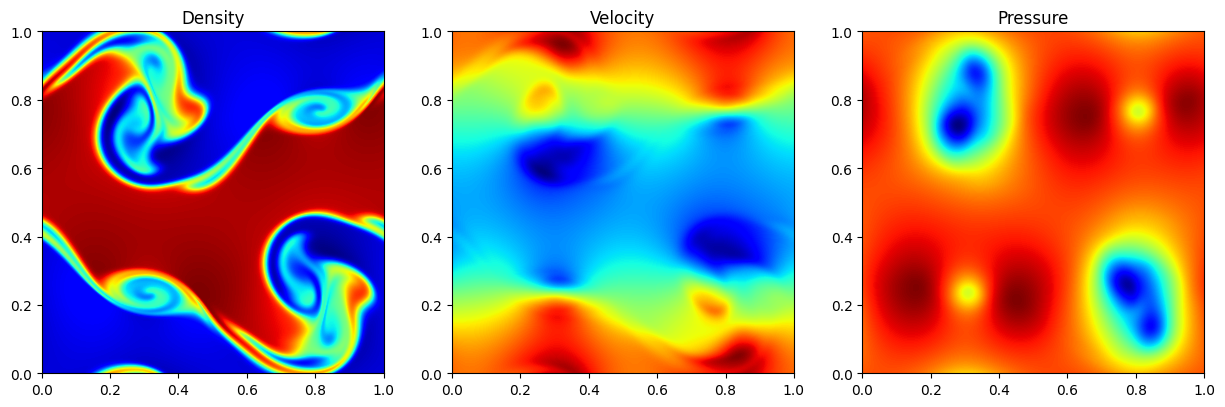

In [7]:
from matplotlib.colors import LogNorm

s = 0.1

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# equal aspect ratio
ax1.set_aspect('equal', 'box')
ax2.set_aspect('equal', 'box')
ax3.set_aspect('equal', 'box')

x = jnp.linspace(0, box_size, num_cells)
y = jnp.linspace(0, box_size, num_cells)

ym, xm = jnp.meshgrid(x, y)

# on the first axis plot the density
# log scaler
norm_rho = LogNorm(vmin = jnp.min(final_state[0, :, :]), vmax = jnp.max(final_state[0, :, :]), clip = True)
norm_p = LogNorm(vmin = jnp.min(final_state[3, :, :]), vmax = jnp.max(final_state[3, :, :]), clip = True)

# ax1.scatter(xm.flatten(), ym.flatten(), c = final_state[0, :, :].flatten(), s = s, norm = norm_rho, marker = "s", cmap = "jet")
# ax1.set_title("Density")

ax1.imshow(final_state[0, :, :].T, norm = norm_rho, cmap = "jet", origin = "lower", extent = [0, box_size, 0, box_size])
ax1.set_title("Density")

# on the second axis plot the absolute velocity
# abs_vel = jnp.sqrt(final_state[1, :, :]**2 + final_state[2, :, :]**2)

# vel_norm = LogNorm(vmin = jnp.min(abs_vel), vmax = jnp.max(abs_vel), clip = True)

ax2.imshow(final_state[1, :, :].T, cmap = "jet", origin = "lower", extent = [0, box_size, 0, box_size])
ax2.set_title("Velocity")

# on the third axis plot the pressure
ax3.imshow(final_state[4, :, :].T, norm = norm_p, cmap = "jet", origin = "lower", extent = [0, box_size, 0, box_size])
ax3.set_title("Pressure")
